# Quick test of wide hydromodpy capabilities

In [1]:

# PYTHON PACKAGES

import sys
import os
import warnings

import numpy as np
import pandas as pd
import flopy
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
import imageio
import whitebox
import rasterio
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
wbt = whitebox.WhiteboxTools()
wbt.verbose = False

# ROOT DIRECTORY

from os.path import dirname, abspath
root_dir = '/home/agauvain/Git/HydroModPy'
sys.path.append(root_dir)
print("Root path directory is: {0}".format(root_dir.upper()))

# HYDROMODPY MODULES

from src import watershed_root
from src.watershed import climatic, geographic, geology, hydraulic, hydrography, hydrometry, intermittency, oceanic, piezometry, subbasin
from src.modeling import downslope, modflow, modpath
from src.display import visualization_watershed, visualization_results, export_vtuvtk
from src.tools import toolbox, folder_root
fontprop = toolbox.plot_params(8,15,18,20) # small, medium, interm, large

# WARNING MANAGEMENT

warnings.filterwarnings("ignore")
    


Root path directory is: /HOME/AGAUVAIN/GIT/HYDROMODPY


In [2]:

regression_path = os.path.join(root_dir, "examples", "00_quick test of wide hydromodpy capabilities/")
data_path = os.path.join(regression_path, "data/")

# The folder out_path is created in the example_path root directory:
out_path = os.path.join(root_dir, "examples", "results")
# Or define it manually
# out_path = 'C:/Simulations/HydroModPy/'

print('The results of the example will be saved here :', out_path)



The results of the example will be saved here : /home/agauvain/Git/HydroModPy/examples/results


In [3]:

# Name of the study site
watershed_name = 'Example_00_Aber'
print('##### '+watershed_name.upper()+' #####')

# Regional DEM
dem_path = os.path.join(data_path, 'regional dem.tif')

# Outlet coordinates of the catchment
from_xyv = [150727.164, 6858066.520, 100, 10 , 'EPSG:2154']

# Extract the catchment from a regional DEM
BV = watershed_root.Watershed(dem_path=dem_path,
                              out_path=out_path,
                              load=False,
                              watershed_name=watershed_name,
                              from_lib=None, # os.path.join(root_dir,'watershed_library.csv')
                              from_dem=None, # [path, cell size]
                              from_shp=None, # [path, buffer size]
                              from_xyv=from_xyv, # [x, y, snap distance, buffer size]
                              bottom_path=None, # path 
                              save_object=True)

# Paths necessary for the script
stable_folder = os.path.join(out_path, watershed_name, 'results_stable')
simulations_folder = os.path.join(out_path, watershed_name, 'results_simulations')



##### EXAMPLE_00_ABER #####
      __  __          __           __  ____          ________     
     / / / /         / /          /  \/   /         / / __  /     
    / /_/ /_  ______/ /________  /       /___  ____/ / /_/ /_  __ 
   / __  / / / / __  / ___/ __ \/ /\,-/ / __ \/ __  / ____/ / / / 
  / / / / /_/ / /_/ / /  / /_/ / /   / / /_/ / /_/ / /   / /_/ /  
 /_/ /_/\__, /_____/_/   \____/_/   /_/\____/_____/_/____\__, /   
       /____/ Hydrological Modelling in Python /_____________/    
                                                                  
Python object was not loaded as requested; it was created from scratch
Extract geography of the model area


In [4]:

# Clip specific data at the catchment scale
BV.add_hydrography(data_path, types_obs=['regional stream network'])



Extract hydrography from specific data


In [5]:

# Name of the model/simulation
model_name = 'reg_0'

# Import modules
BV.add_settings()
BV.add_climatic()
BV.add_hydraulic()
BV.add_oceanic('None')

# Frame settings
BV.settings.update_model_name(model_name) # Name of the model/simulation
BV.settings.update_box_model(True)
BV.settings.update_sink_fill(False)
BV.settings.update_simulation_state('transient') # steady
BV.settings.update_check_model(plot_cross=True, check_grid=True)
BV.settings.update_dis_perlen(dis_perlen=True)

# Climatic settings
time_index = pd.date_range(start='2017-01-01', end='2017-12-31', freq='M') # datetime in months
rch_series = pd.Series([10, 60, 40, 20, 10, 5, 4, 20, 10, 1, 0, 0]) / 1000 / 30 # recharge mm/month to in m/day
recharge = pd.Series(rch_series.values, index=time_index)
BV.climatic.update_recharge(recharge, sim_state=BV.settings.sim_state)
BV.climatic.update_runoff(None, sim_state=BV.settings.sim_state)
BV.climatic.update_first_clim('mean') # or 'first or value

# Well settings
well_1_coords = [1-1,9-1,29-1] # [lay, row, col]
well_2_coords = [1-1,17-1,29-1] # [lay, row, col]
well_1_fluxes = pd.Series([-200, 0, -100, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # [L3/T]
well_2_fluxes = pd.Series([-500, 0, 0, -500, 0, 0, -500, 0, 0, 0, 0, 0]) # [L3/T]
BV.settings.update_well_pumping(well_coords=[well_1_coords, well_2_coords],
                                well_fluxes=[well_1_fluxes, well_2_fluxes])

# Hydraulic settings
BV.hydraulic.update_bottom(None) # Set a value to set a flat bottom
BV.hydraulic.update_thick(50) # Not consider if bottom != of None
BV.hydraulic.update_nlay(1)
BV.hydraulic.update_lay_decay(1) # 1 if not activated
BV.hydraulic.update_hk(1e-5 * 24 * 3600) # m/d
BV.hydraulic.update_sy(1/100) # -
BV.hydraulic.update_ss(1e-5) # -
BV.hydraulic.update_hk_decay(0, None, False) # alpha, kmin, log_transf
BV.hydraulic.update_sy_decay(0, None, False)
BV.hydraulic.update_ss_decay(0, None, False)
BV.hydraulic.update_hk_vertical(None) # or [ [1e-5, [0, 20]], [1e-6, [20,80]] ]
BV.hydraulic.update_sy_vertical(None) # or [ [1e-5, [0, 20]], [1e-6, [20,80]] ]
BV.hydraulic.update_vka(1) # anisotropy ratio Kxy/Kz
BV.hydraulic.update_cond_drain(None)

# Boundary settings
BV.settings.update_bc_sides(None, None)

# Particle tracking settings
BV.settings.update_input_particles(zone_partic = os.path.join(simulations_folder,model_name,'_postprocess/_rasters/seepage_areas_t(0).tif'),
                                    cell_div = 1, # 1
                                    zloc_div = False,  # True or False, add cells in vertical
                                    bore_depth = None, # True or None, inject in each lay
                                    track_dir = 'backward',
                                    sel_random = None, # or int
                                    sel_slice = None, # or int
                                    )



Init settings module to set model parameter
Init climatic module to set model parameter
Init hydraulic module to set model parameter


Check model grid: all cells satisfy the water flow connectivity condition
FloPy is using the following executable to run the model: ../../../../../bin/linux/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: reg_0.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/01/09 12:04:24

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Groundwater-Flow Eqn.
 Sol

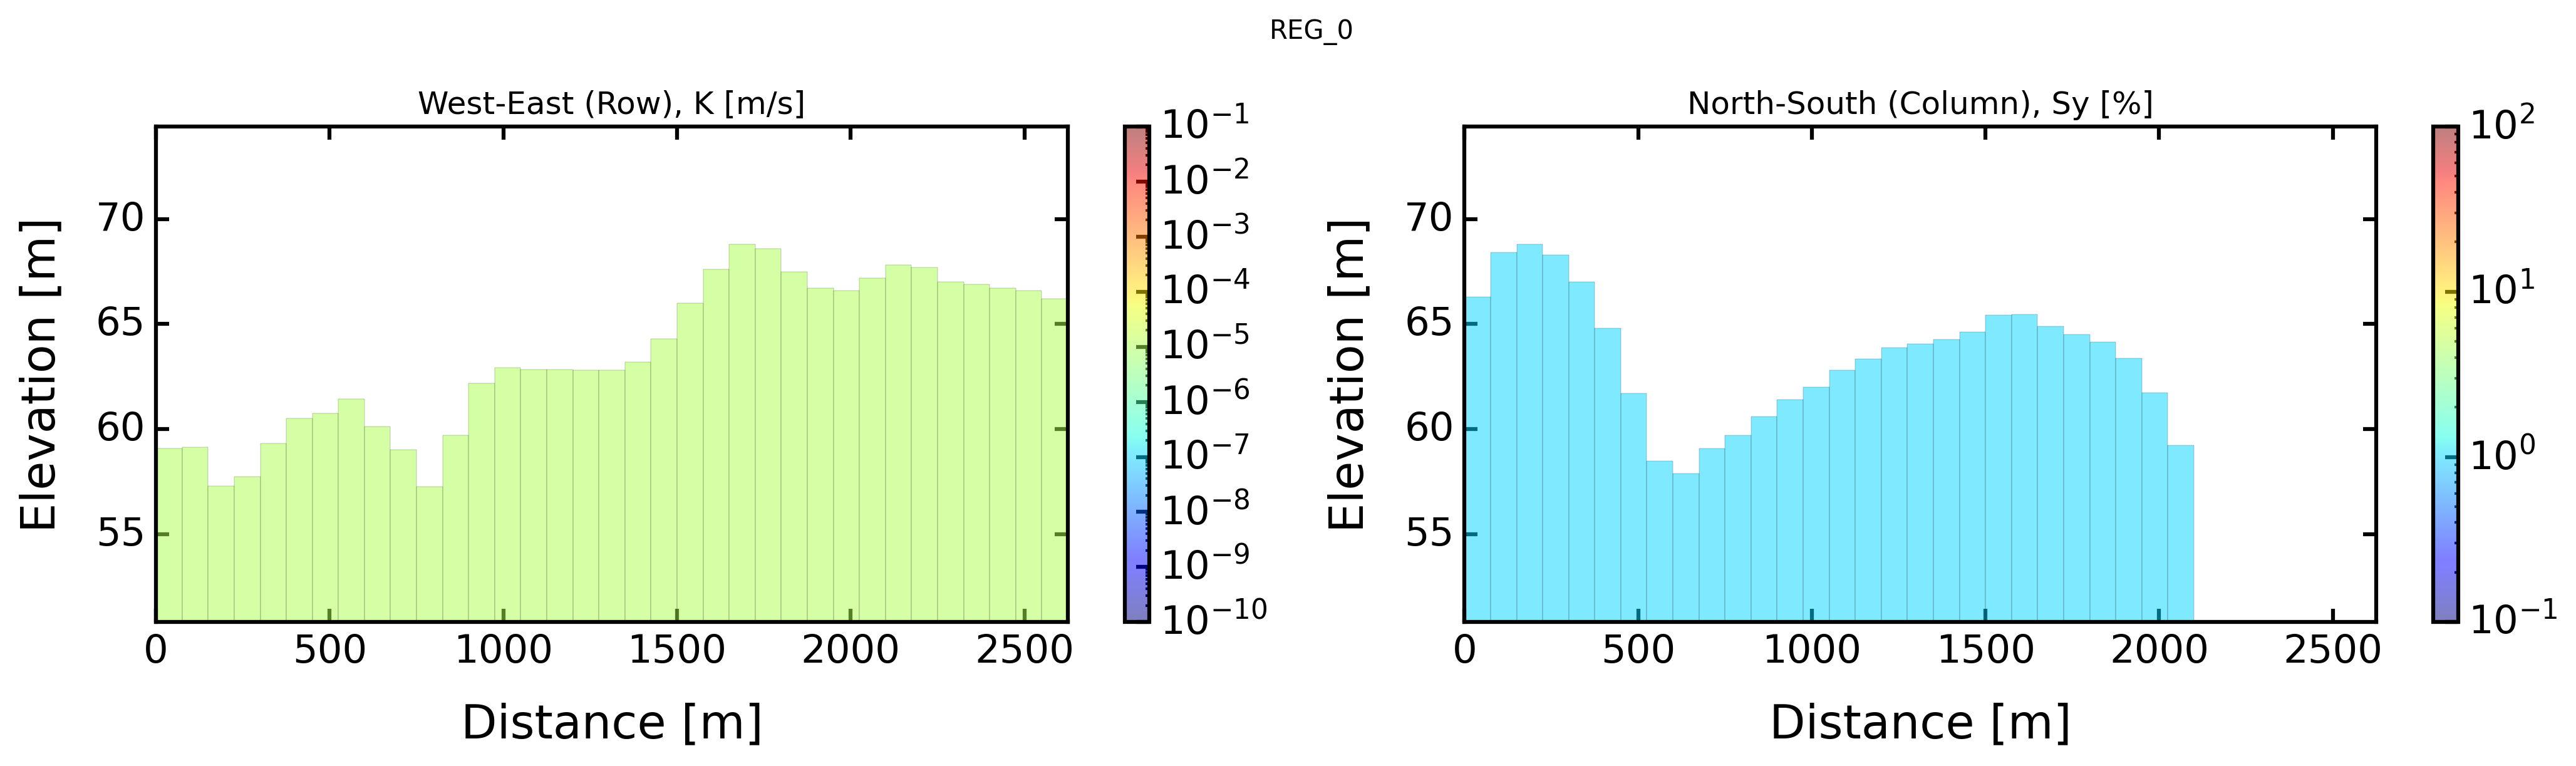

In [6]:

# Pre-processing
model_modflow = BV.preprocessing_modflow(for_calib=False)

# Processing
success_modflow = BV.processing_modflow(model_modflow, write_model=True, run_model=True)

# Post-processing
BV.postprocessing_modflow(model_modflow,
                          watertable_elevation=True,
                          watertable_depth=True, 
                          seepage_areas=True,
                          outflow_drain=True,
                          groundwater_flux=True,
                          groundwater_storage=True,
                          accumulation_flux=True,
                          persistency_index=True, # only in transient
                          intermittency_monthly=True, # only in transient
                          intermittency_weekly=False, # only in transient
                          intermittency_daily=False, # only in transient
                          export_all_tif=True)

BV.postprocessing_netcdf(model_modflow,
                         datetime_format=False)



In [7]:

# Pre-processing
model_modpath = BV.preprocessing_modpath(model_modflow)

# Processing
success_modpath = BV.processing_modpath(model_modpath, write_model=True, run_model=True)

# Post-processing
if success_modpath == True:
    BV.postprocessing_modpath(model_modpath,
                              ending_point=True,
                              starting_point=True,
                              pathlines_shp=True,
                              particles_shp=False,
                              random_id=None) # None
    
    BV.filtprocessing_modpath(model_modpath,
                              norm_flux=True, # for forward only
                              filt_time=True, # delete particles with time at 0, add a column with time divided by 365 (considering recharge in days)
                              filt_seep=True, # only forward, keep only particles finishing in zone1 (seepage), keep only particles finishing in k1 (first layer)
                              filt_inout=True, # delete particles in and out in the same cell (first layer)
                              calc_rtd=True, # compute residence time distribution
                              random_id=None, # select randomly to keep
                              ) # None



writing loc particle data
FloPy is using the following executable to run the model: ../../../../../bin/linux/mp6
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00                                                                       
Particle tracking complete. Writing endpoint file ...                                                                               
End of MODPATH simulation. Normal termination.
(numpy.record, [('particleid', '<i4'), ('particlegroup', '<i4'), ('timepointindex', '<i4'), ('cumulativetimestep', '<i4'), ('time', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('k', '<i4'), ('i', '<i4'), ('j', '<i4'), ('grid', '<i4'), ('xloc', '<f4'), ('yloc', '<f4'), ('zloc', '<f4'), ('linesegmentindex', '<i4')])


In [8]:

timeseries_results = BV.postprocessing_timeseries(model_modflow=model_modflow,
                                                  model_modpath=model_modpath,
                                                  datetime_format=False, 
                                                  subbasin_results=True,
                                                  intermittency_monthly=True, # only in transient
                                                  intermittency_weekly=False, # only in transient
                                                  intermittency_daily=False, # only in transient                        
                                                  ) # or 'M' or None



   Export results as timeseries


In [9]:

sim_contour = gpd.read_file(BV.geographic.watershed_shp)
sim_dem_data = imageio.imread(BV.geographic.watershed_box_buff_dem)
sim_wte_rio = rasterio.open(BV.simulations_folder+'/'+model_name+'/_postprocess/_rasters/watertable_elevation_t(0).tif')
sim_wte_data = sim_wte_rio.read(1)
sim_wtd_rio = rasterio.open(BV.simulations_folder+'/'+model_name+'/_postprocess/_rasters/watertable_depth_t(0).tif')
sim_wtd_data = sim_wtd_rio.read(1)
sim_seep_rio = rasterio.open(BV.simulations_folder+'/'+model_name+'/_postprocess/_rasters/seepage_areas_t(0).tif')
sim_seep_data = np.ma.masked_where(sim_seep_rio.read(1)<=0, sim_seep_rio.read(1))
sim_pathlines = gpd.read_file(BV.simulations_folder+'/'+model_name+'/_postprocess/_particles/pathlines_weighted.shp')
sim_timeseries = pd.read_csv(BV.simulations_folder+'/'+model_name+'/_postprocess/_timeseries/_simulated_timeseries.csv', sep=';', index_col=0, parse_dates=True)



PLOT: WATERSHED INFO
  Plot 2D maps visualization


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


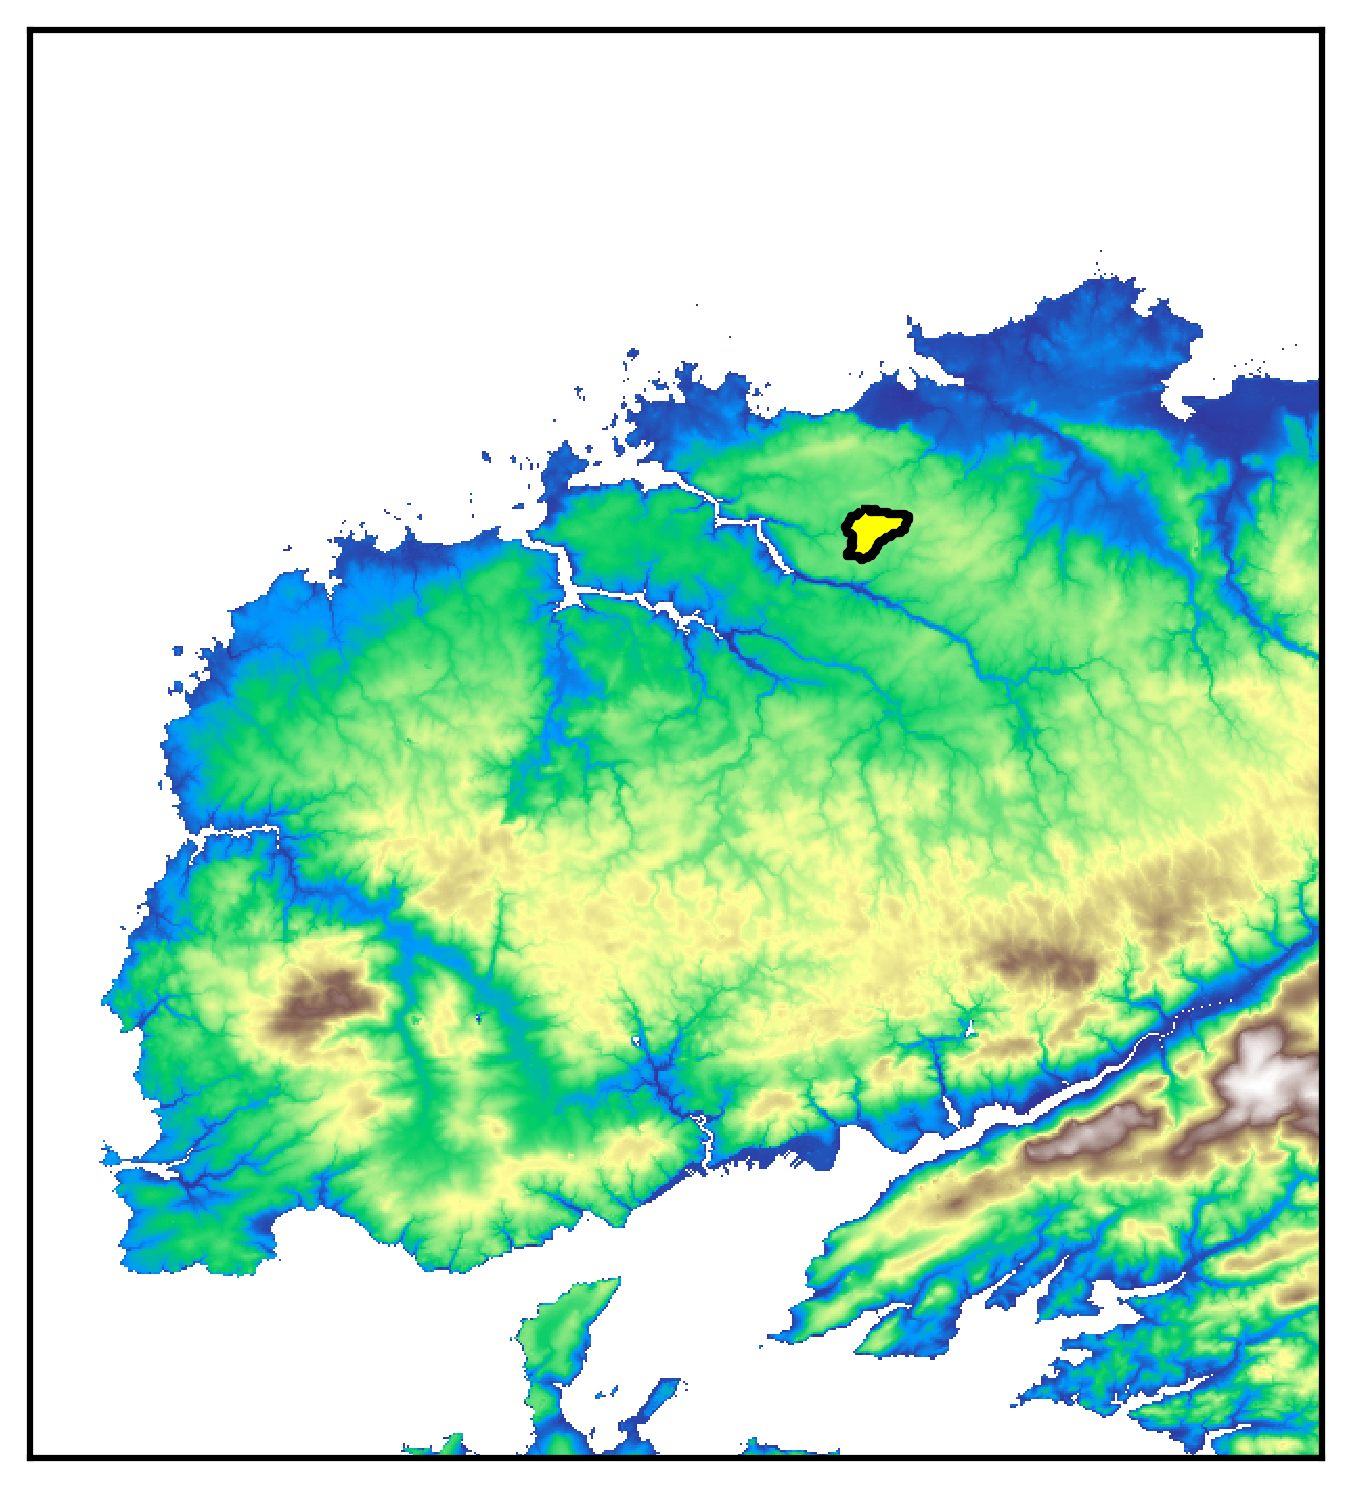

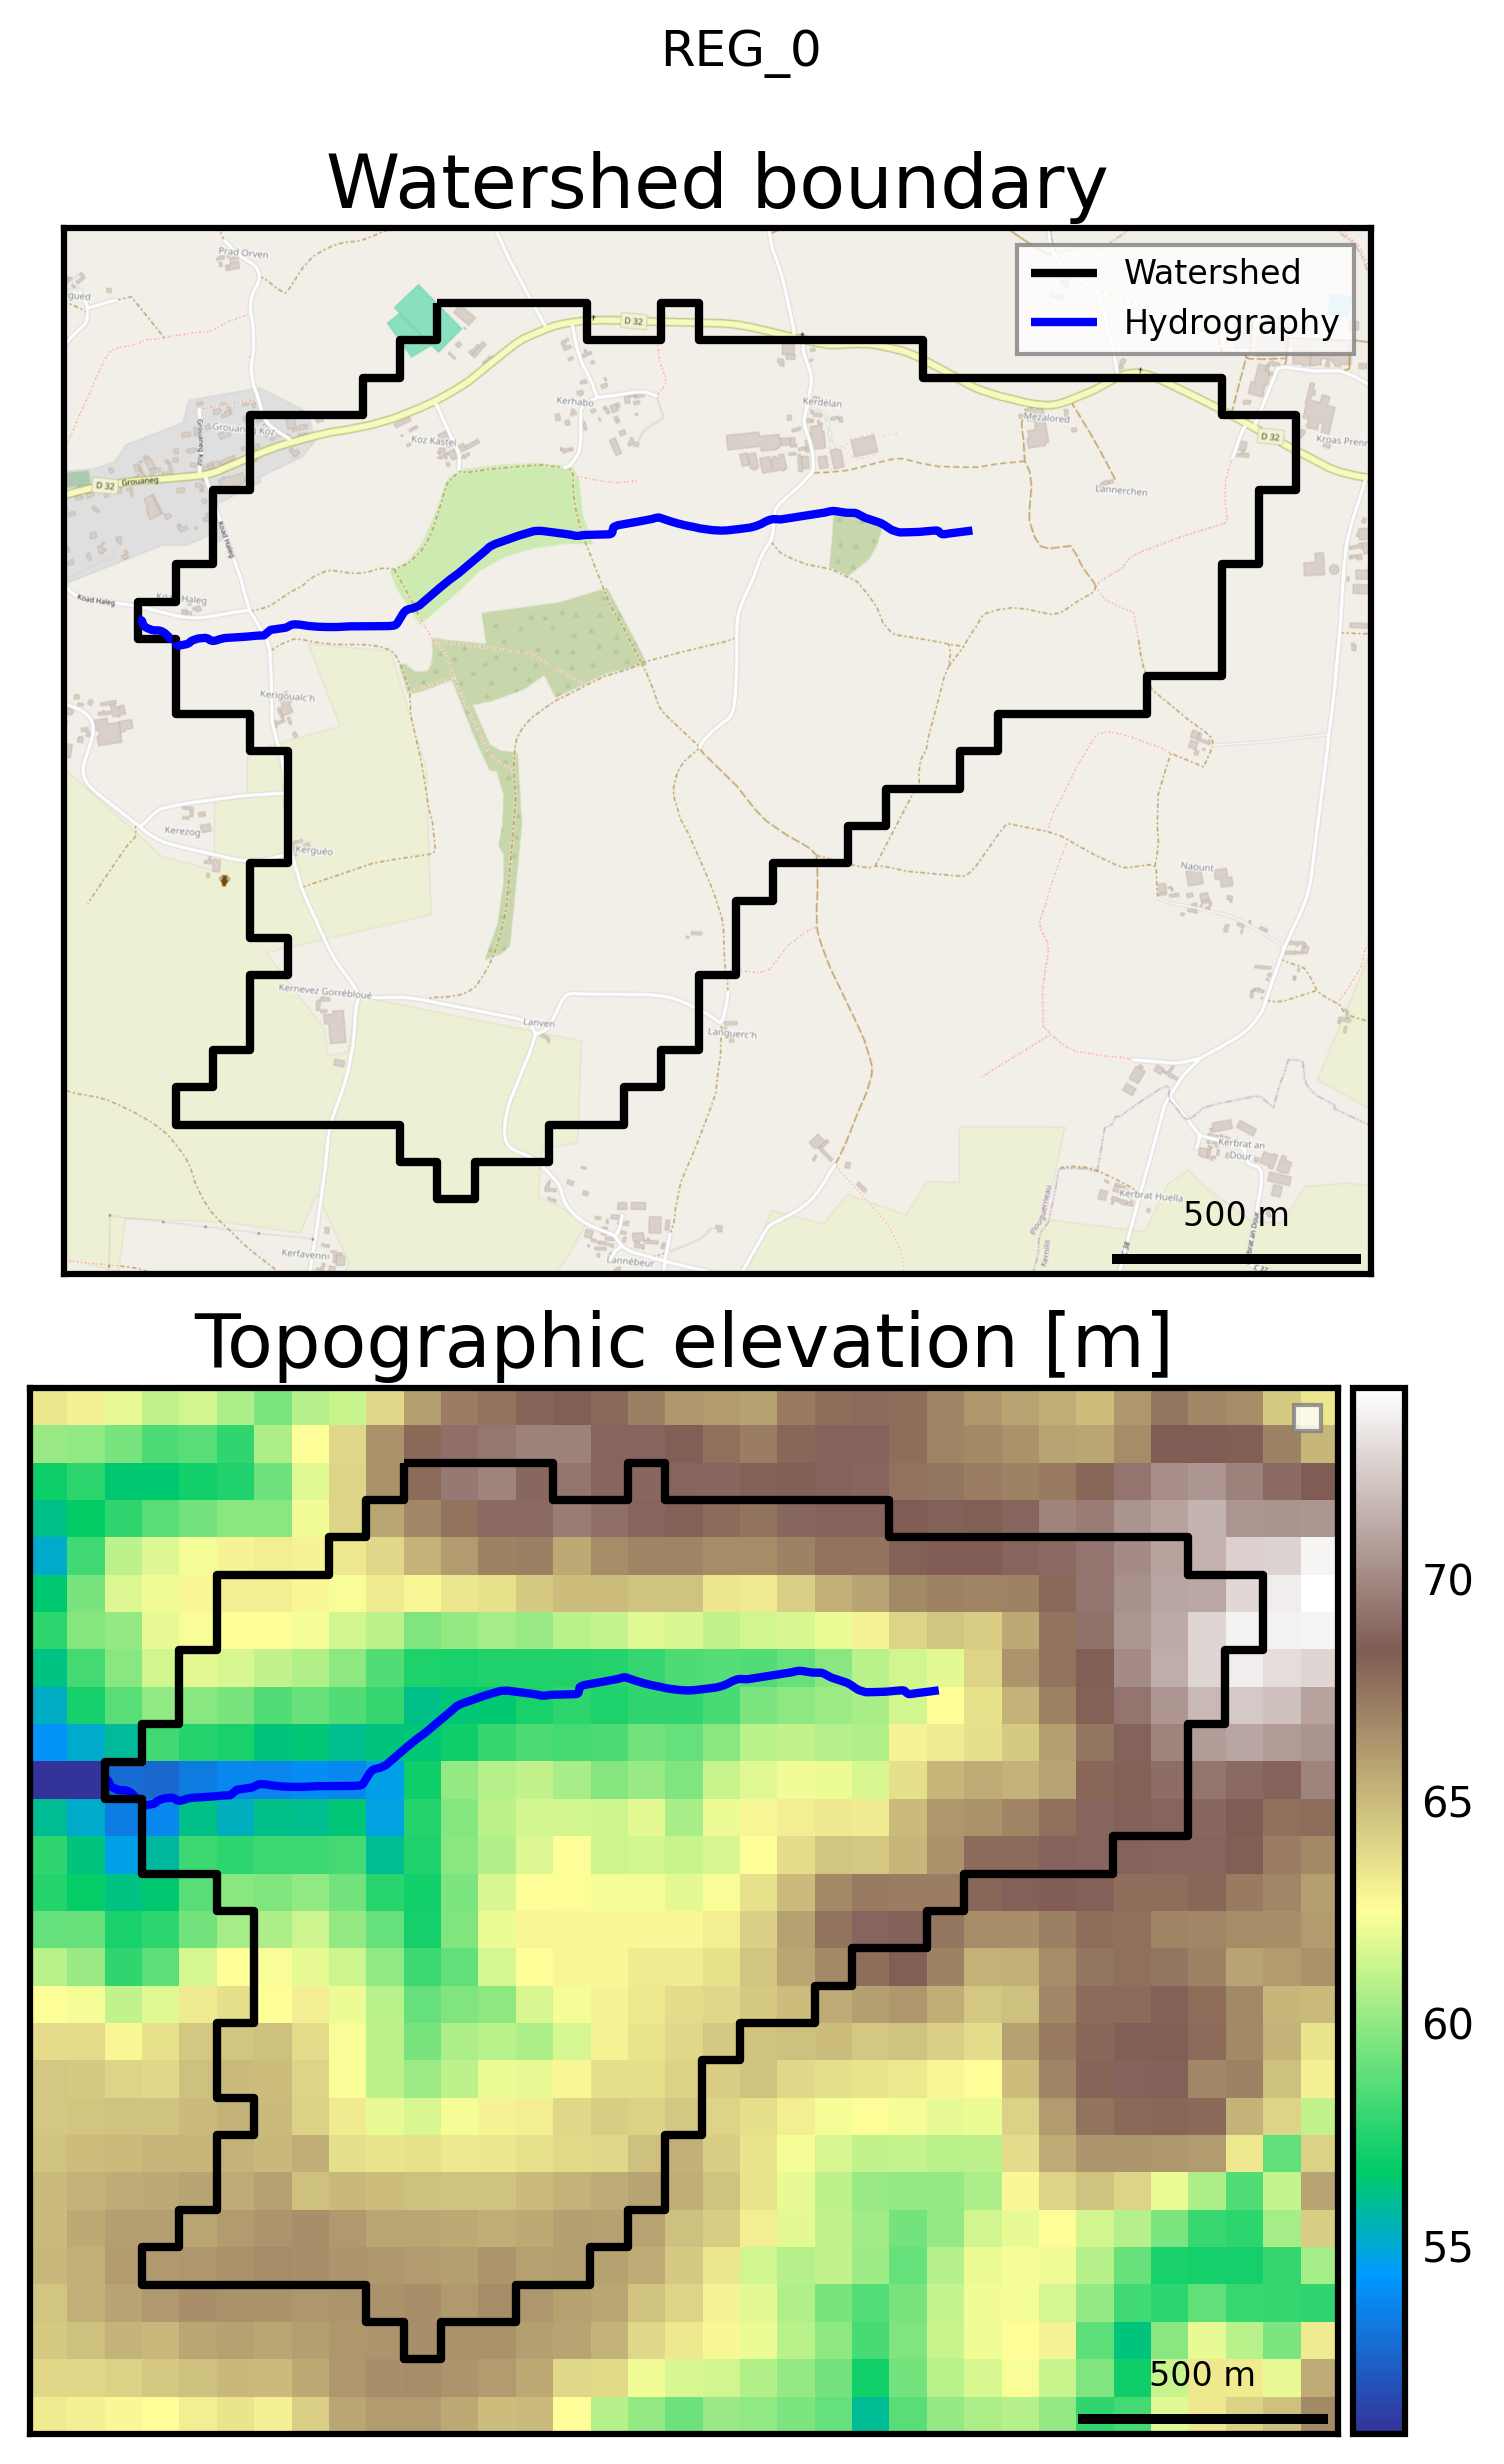

In [10]:

print('PLOT: WATERSHED INFO')

# General plot of the study site
visualization_watershed.watershed_local(dem_path, BV)
visu = visualization_results.Visualization(BV, model_name)
visu.visual2D(object_list = ['map','grid'], color_scale = [(None,None),(None,None)], lines=None)



PLOT: MAPS


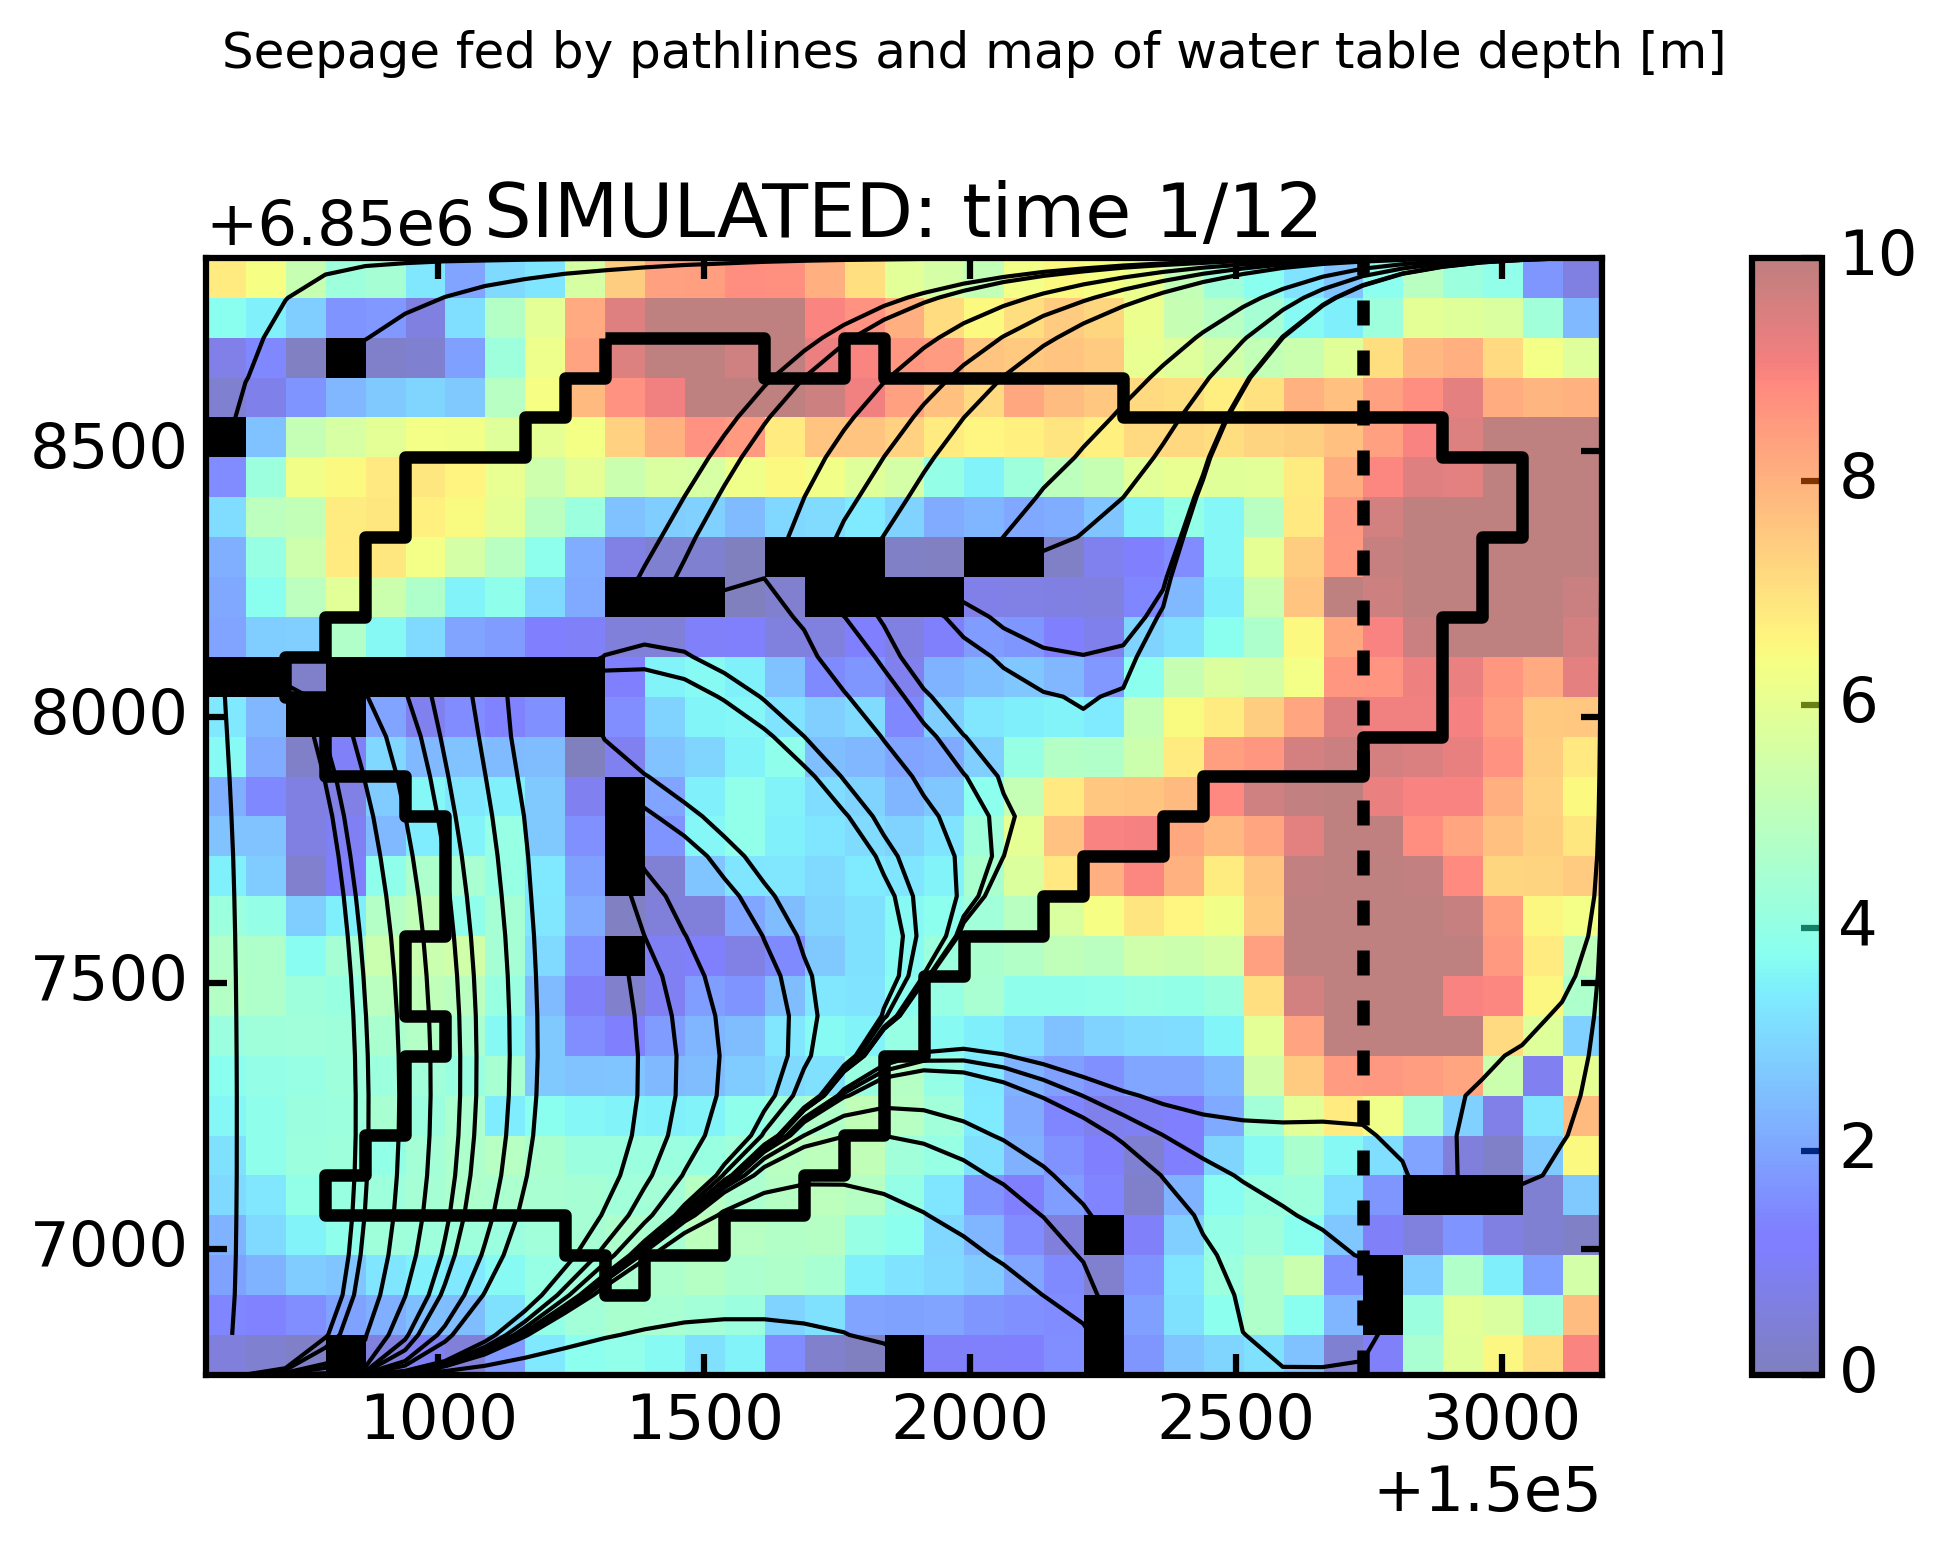

In [11]:

print('PLOT: MAPS')

fig, ax = plt.subplots(1,1, figsize=(8, 5), dpi=300)

sim_wtd = rasterio.plot.show(sim_wtd_data, ax=ax, transform=sim_wtd_rio.transform, cmap='jet',
                             vmin=0, vmax=10, alpha=0.5, zorder=0, aspect="auto")
rasterio.plot.show(sim_seep_data, ax=ax, transform=sim_seep_rio.transform, cmap=mpl.colors.ListedColormap(['k']), alpha=1, zorder=1, aspect="auto")
sim_contour.plot(ax=ax, lw=3, ec='k', fc='None')
sim_pathlines.plot(ax=ax, color='k')
ax.set_title('SIMULATED: time 1/12')
im = sim_wtd.get_images()[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.5)
fig.colorbar(im, cax=cax)
ax.axvline(x=ax.get_xlim()[0]+((29)*75), color='k', ls='--', lw=3)

fig.suptitle('Seepage fed by pathlines and map of water table depth [m]', y=1.02, fontsize=12)
fig.tight_layout()



PLOT: CROSS-SECTION


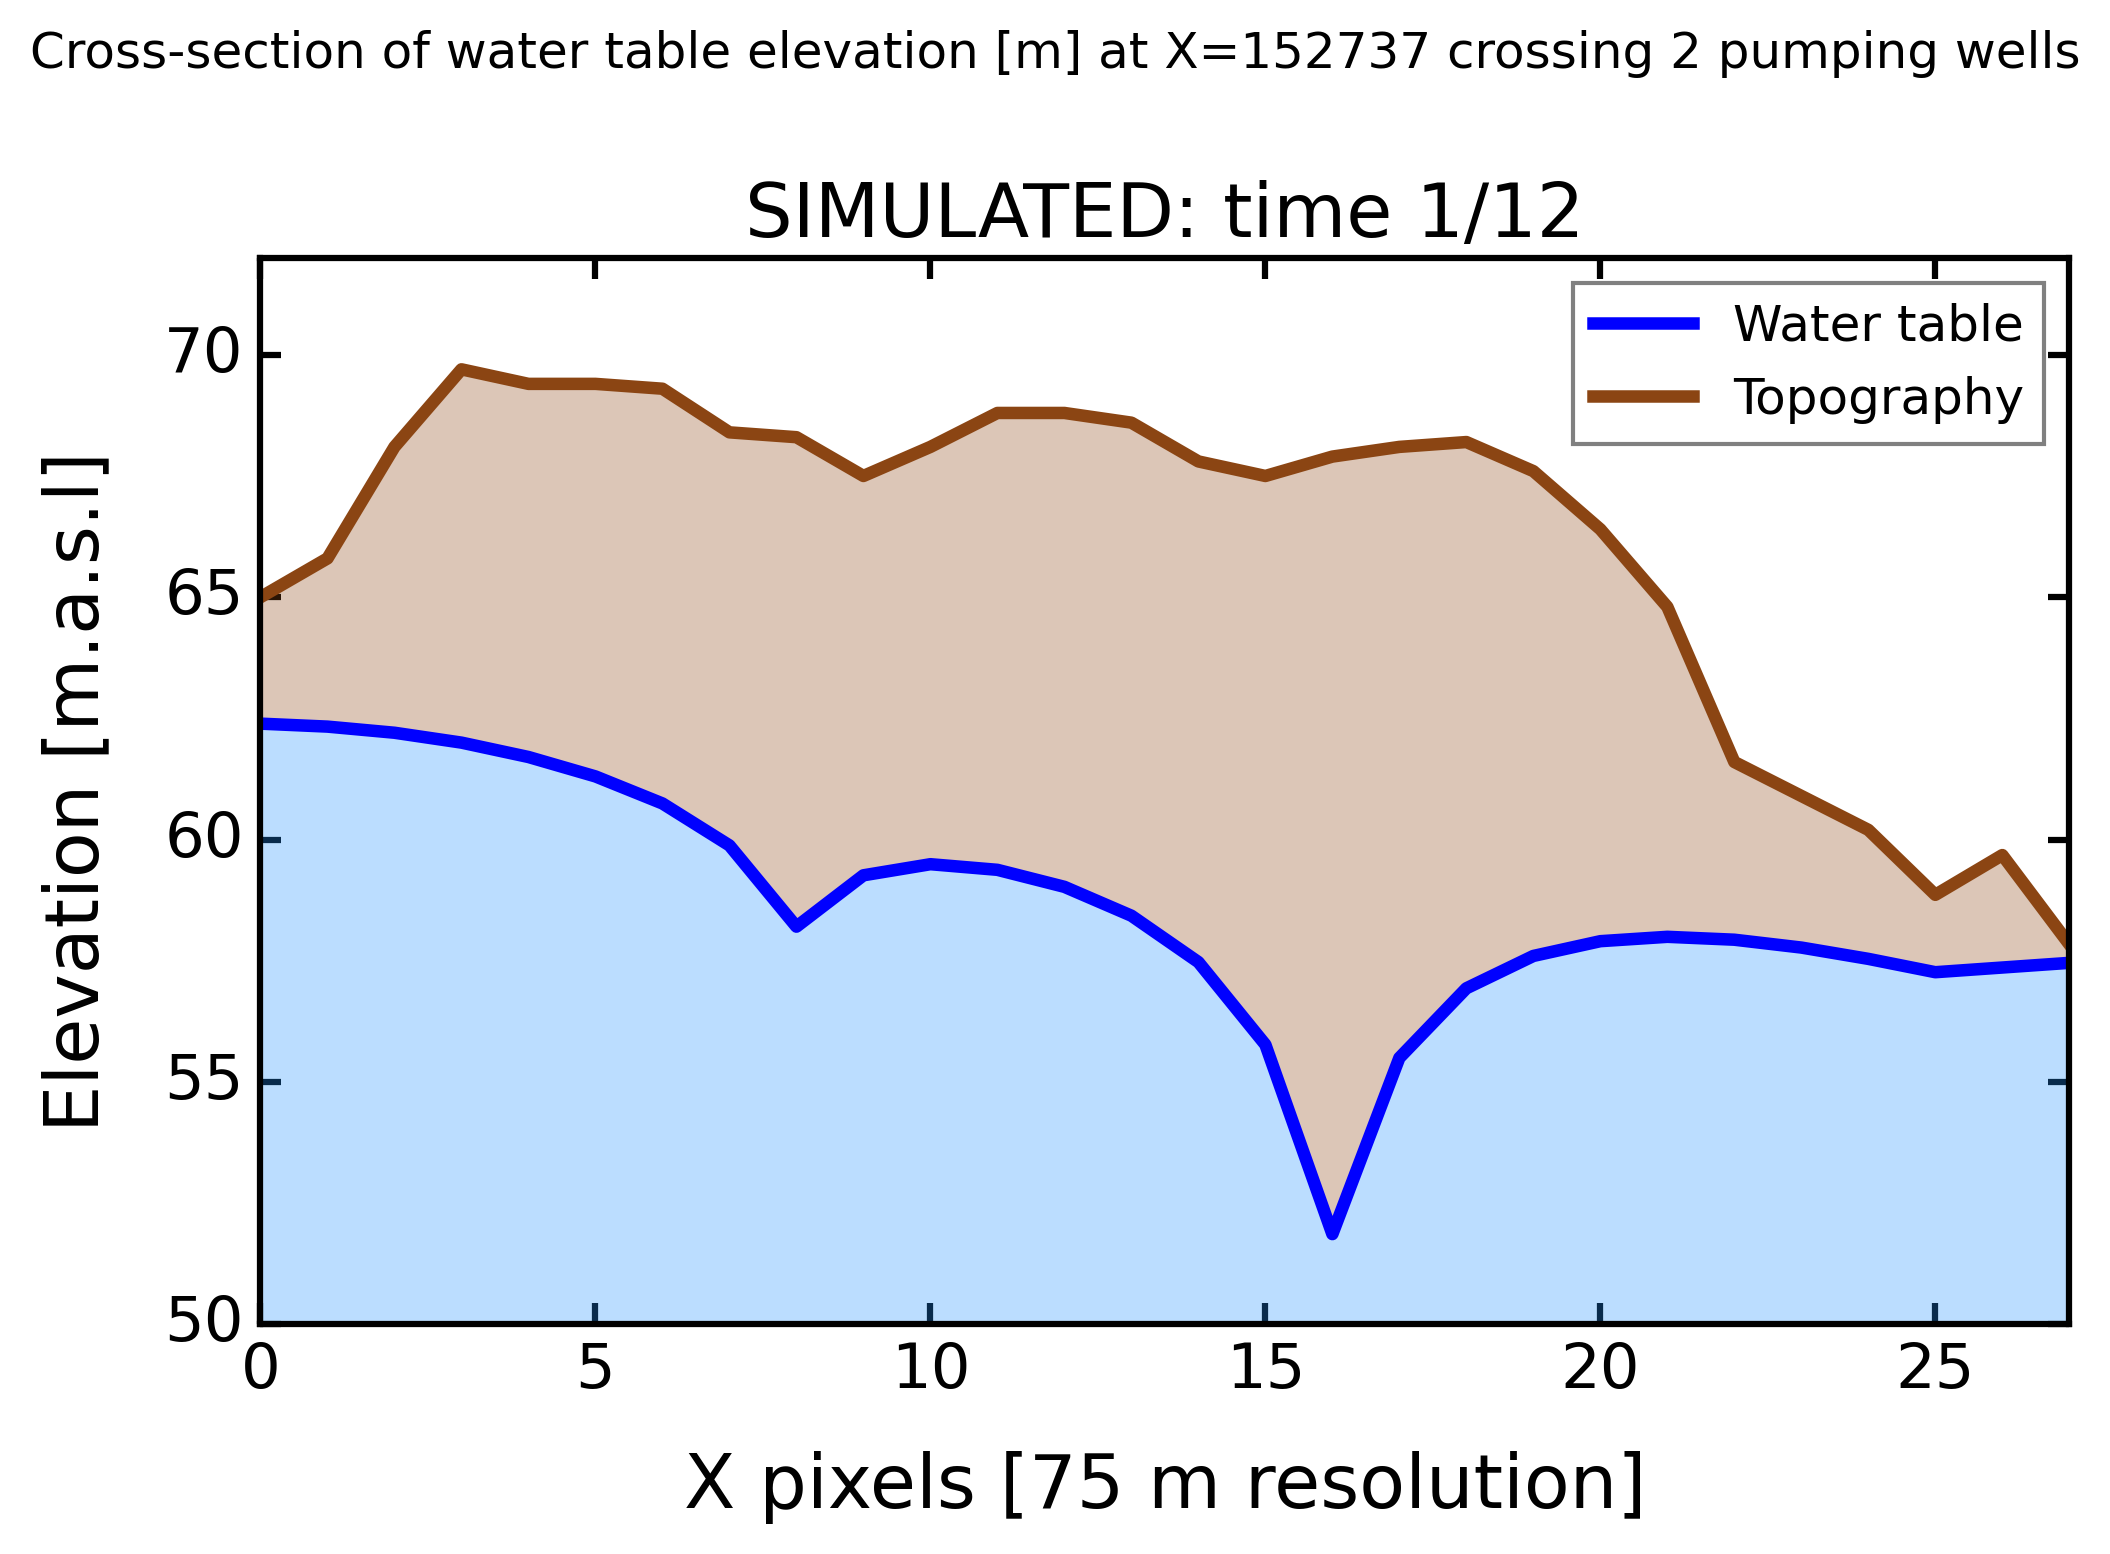

In [12]:

print('PLOT: CROSS-SECTION')

fig, ax = plt.subplots(1,1, figsize=(7, 5), dpi=300)

x_sim_wte = np.arange(0,sim_wte_data.shape[0],1)
y_sim_wte = sim_wte_data[:,28:29]
y_sim_wte = np.concatenate(y_sim_wte, axis=0)
ax.fill_between(x_sim_wte, x_sim_wte*0, y_sim_wte, lw=0, alpha=0.3, color='dodgerblue')
ax.plot(x_sim_wte, y_sim_wte, lw=3, color='blue', label='Water table')

x_sim_dem = np.arange(0,sim_dem_data.shape[0],1)
y_sim_dem = sim_dem_data[:,28:29]
y_sim_dem = np.concatenate(y_sim_dem, axis=0)
ax.fill_between(x_sim_dem, y_sim_wte, y_sim_dem, lw=0, alpha=0.3, color='saddlebrown')
ax.plot(x_sim_dem, y_sim_dem, lw=3, color='saddlebrown', label='Topography')

ax.set_xlim(0,27)
ax.set_ylim(50,72)
ax.legend(prop={'size': 12})
ax.set_xlabel('X pixels [75 m resolution]')
ax.set_ylabel('Elevation [m.a.s.l]')
ax.set_title('SIMULATED: time 1/12')

fig.suptitle('Cross-section of water table elevation [m] at X=152737 crossing 2 pumping wells', y=1.02, fontsize=12)
fig.tight_layout()



PLOT: GRAPHS


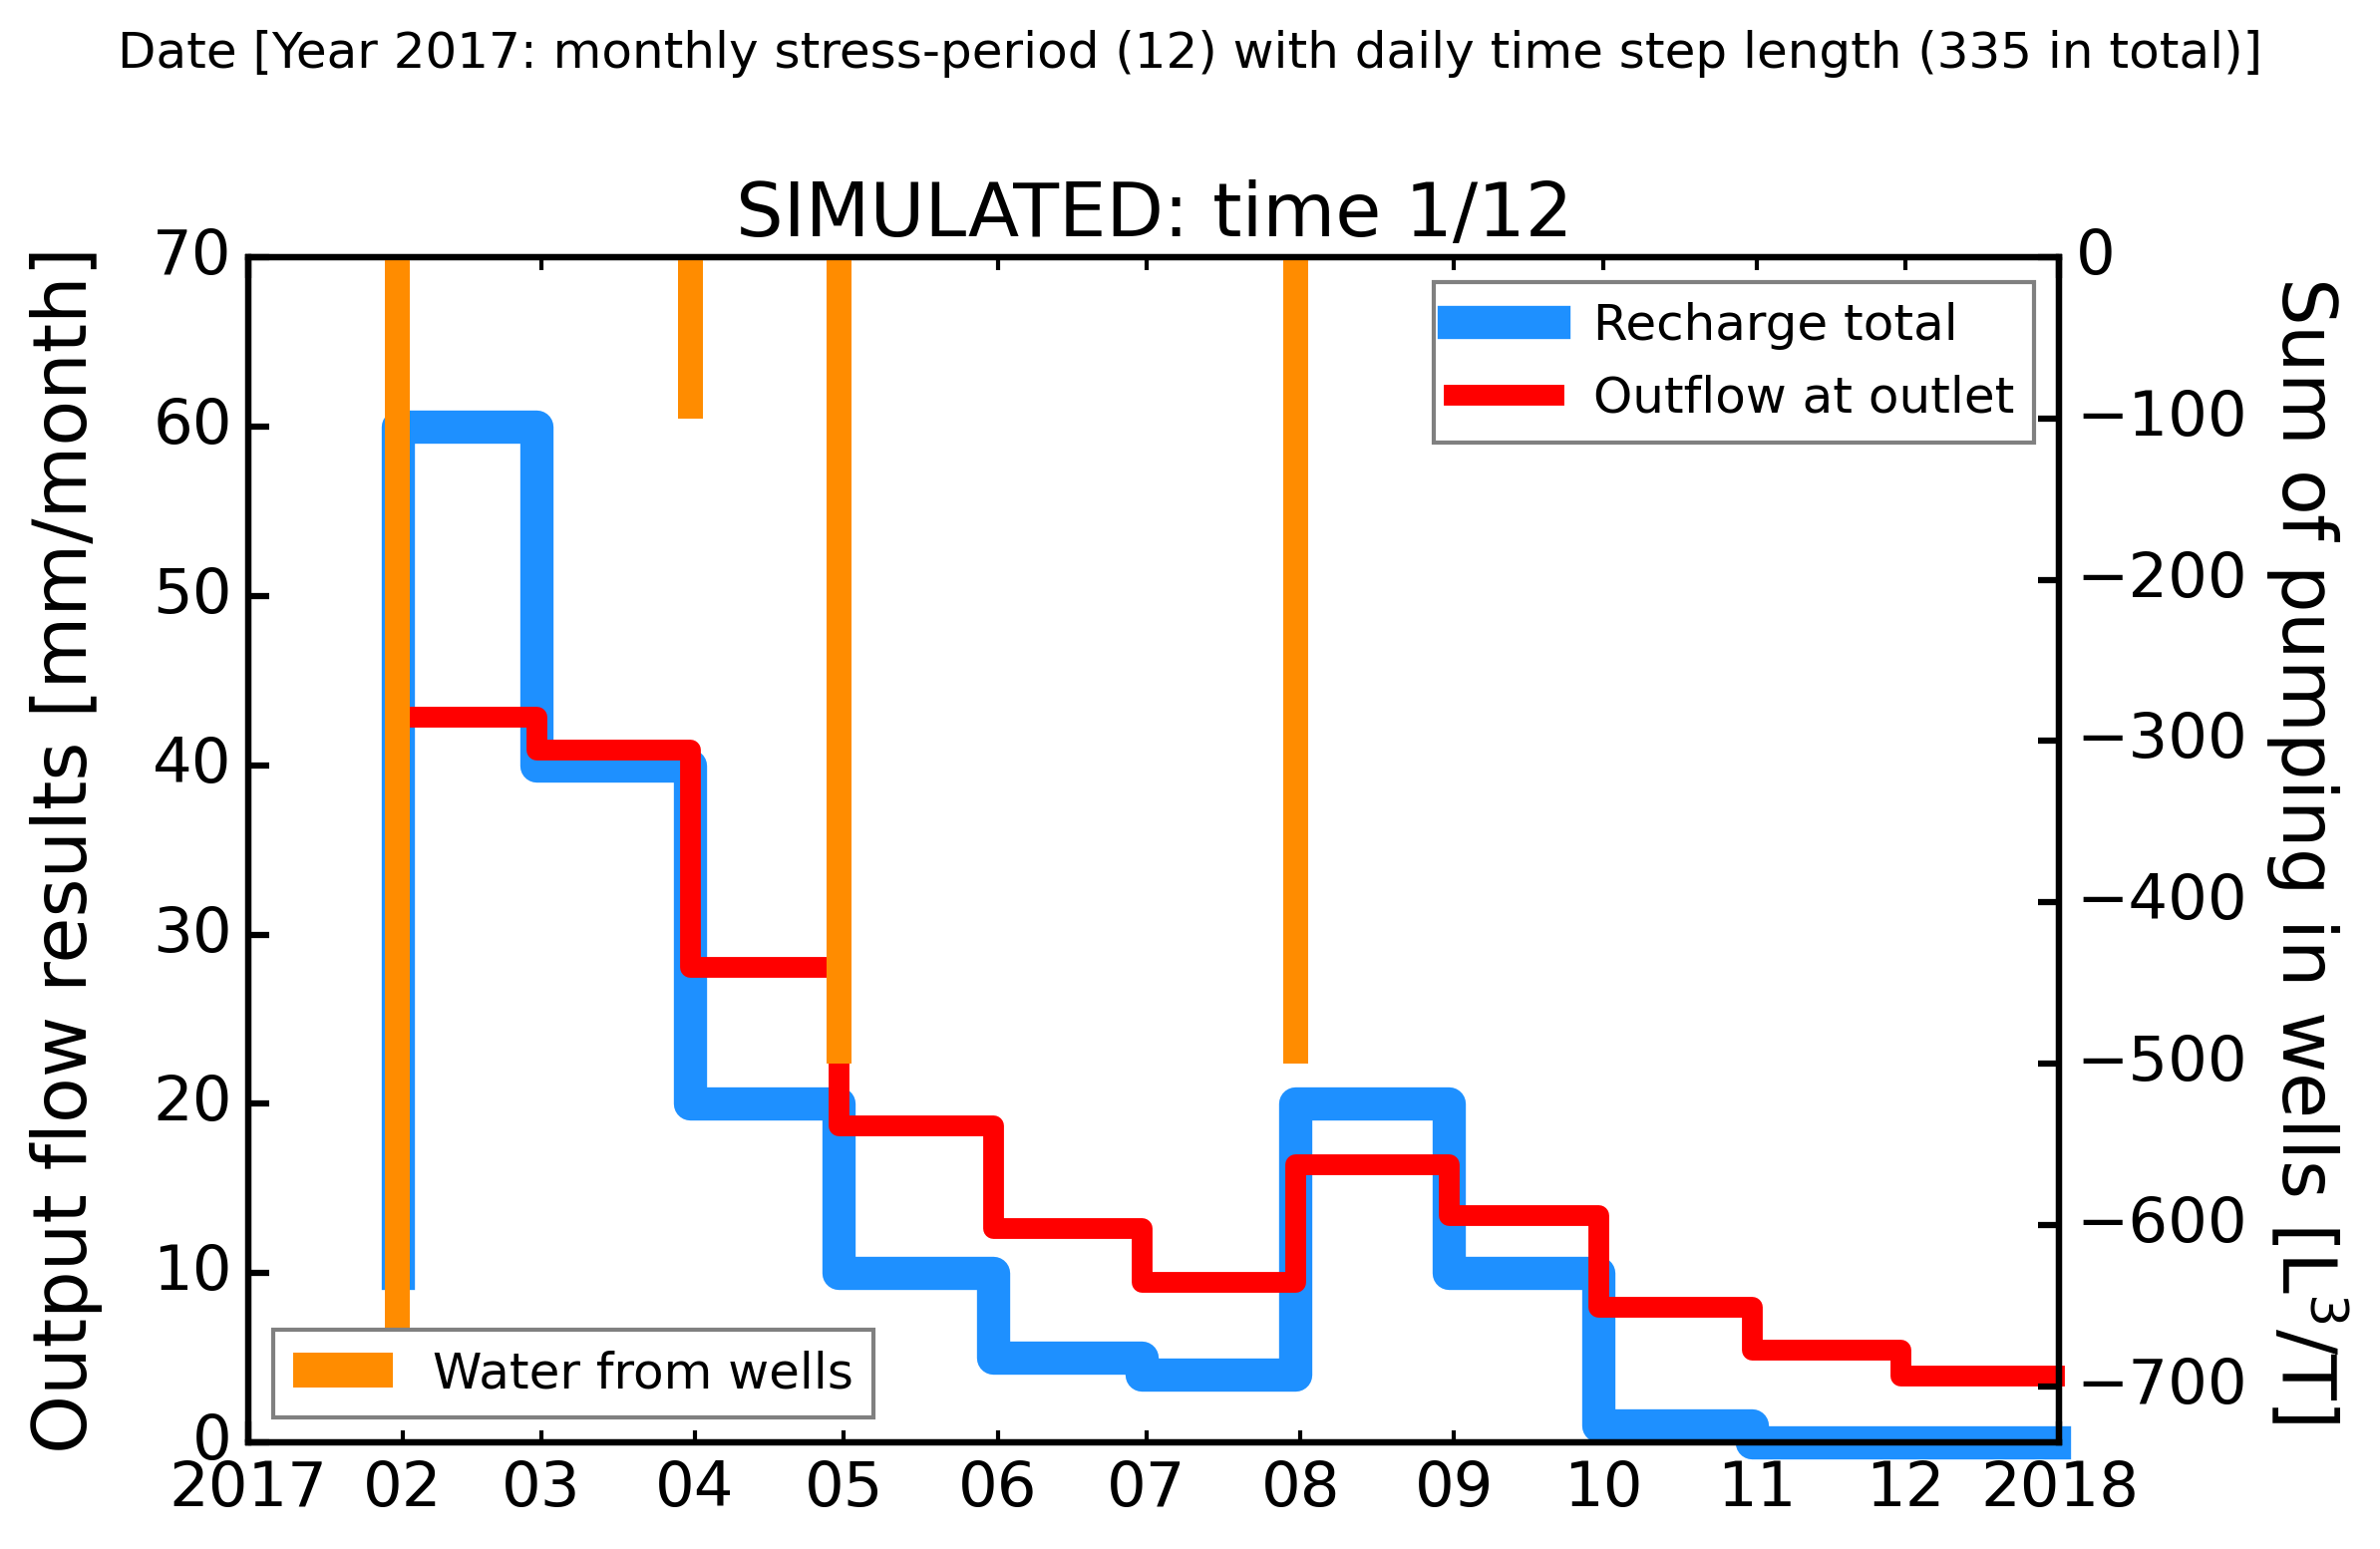

In [13]:

print('PLOT: GRAPHS')

well_1_fluxes_plot = well_1_fluxes.copy()
well_1_fluxes_plot.index = sim_timeseries.index
well_2_fluxes_plot = well_2_fluxes.copy()
well_2_fluxes_plot.index = sim_timeseries.index
well_all_fluxes_plot = well_1_fluxes_plot + well_2_fluxes_plot

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300)

axb = ax.twinx()
ax.step(sim_timeseries.index, sim_timeseries['recharge']*30*1000, lw=8, color='dodgerblue', label='Recharge total', where='pre', clip_on=False)
ax.step(sim_timeseries.index, sim_timeseries['outflow_drain']*30*1000, lw=5, color='red', alpha=1, label='Outflow at outlet', where='pre', clip_on=False)
ax.set_xlim(pd.to_datetime('2017-01'), pd.to_datetime('2018-01'))
ax.set_ylabel('Output flow results [mm/month]')
ax.set_ylim(0, 70)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))
ax.legend(prop={'size': 12})
axb.bar(sim_timeseries.index, well_all_fluxes_plot, clip_on=False, width=5, lw=0, color='darkorange', label='Water from wells')
# axb.set_ylim(-110,0)
axb.set_ylabel('Sum of pumping in wells [L$^3$/T]', rotation=270, labelpad=25)
ax.set_title('SIMULATED: time 1/12')
axb.legend(prop={'size': 12}, loc='lower left', facecolor='white')

fig.suptitle('Date [Year 2017: monthly stress-period (12) with daily time step length (335 in total)]', y=1.02, fontsize=12)
fig.tight_layout()



In [14]:

os.chdir(root_dir)
